<a href="https://colab.research.google.com/github/SajjadAlavi98/DeepLearningTrainings/blob/main/Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=f1244042241811df37d68d78e4347adf84802dff3f4b387a4a1955f86bd3ce44
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=52dc3fc7c2644b74e862adcfb88b8

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

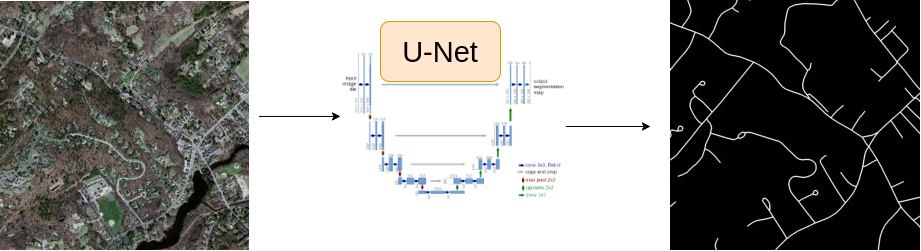

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 18.76 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATDA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head(5)


,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 10

row = df.iloc[idx]

image_path = DATDA_DIR + row.images
mask_path = DATDA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

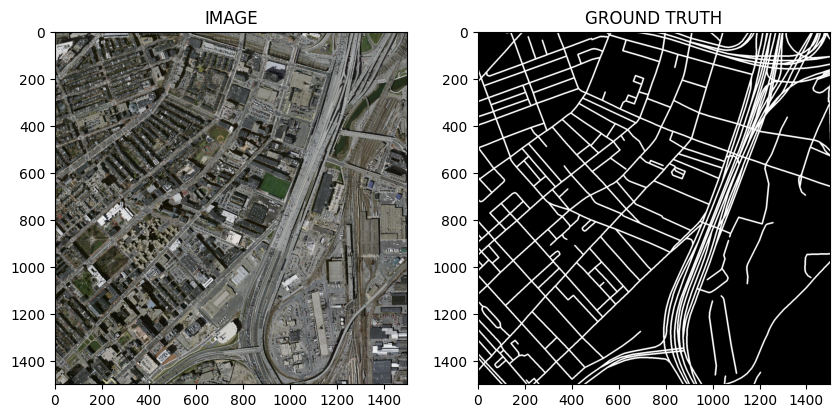

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
len(train_df), len(valid_df)

(159, 40)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
      self.df = df
      self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
      row = self.df.iloc[idx]

      image_path = DATDA_DIR + row.images
      mask_path = DATDA_DIR + row.masks

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # (h, w, c)

      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (h, w)
      mask = np.expand_dims(mask, axis=-1)  # (h, w, c)

      if self.augmentations:
        data = self.augmentations(image=image, mask=mask)
        image = data['image'] # (h, w, c)
        mask = data['mask']

      # shift (h, w, c) -> (c, h, w) since we use PyTorch
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # c:axis=2
      mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

      # convert to Tensor
      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)  # to 0 and 1 (we have 2 classes)

      return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
len(trainset), len(validset)

(159, 40)

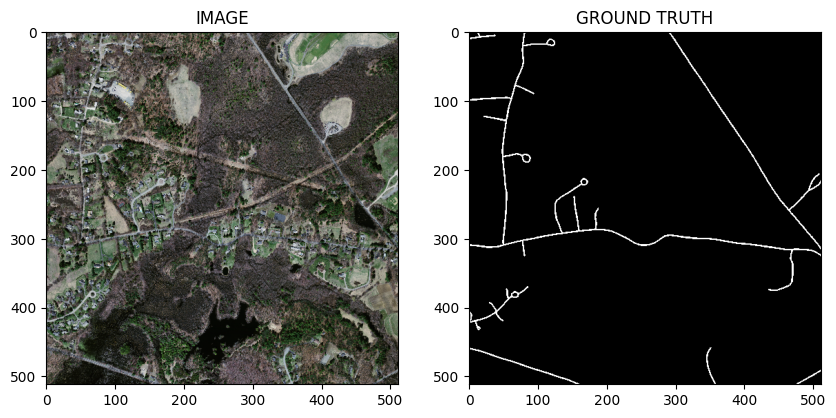

In [ ]:
idx = 58

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 20
total no. of batches in validloader : 5


In [ ]:
for image, mask in trainloader:
  print(f'One batch image shape : {image.shape}')
  print(f'One batch mask shape : {mask.shape}')
  break

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None # output will be raw
    )

  def forward(self, images, masks=None):
    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 17.8MB/s]


# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader: DataLoader, model: SegmentationModel, optimizer):
  model.train() # to turn ON dropout, batchnorm, etc.
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward() # calc gradient
    optimizer.step()  # update parameters

    total_loss += loss.item()

  return total_loss / len(data_loader)  # divide by number of batch

In [ ]:
def eval_fn(data_loader: DataLoader, model: SegmentationModel):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

    return total_loss / len(data_loader)


# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt') # .pt = pytorch
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print('Epoch: %d -- train_loss: %f -- valid_loss: %f'%(i+1, train_loss, valid_loss))

100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


SAVED-MODEL
Epoch: 1 -- train_loss: 1.031922 -- valid_loss: 1.031881


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


SAVED-MODEL
Epoch: 2 -- train_loss: 0.782356 -- valid_loss: 0.835054


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 3 -- train_loss: 0.727091 -- valid_loss: 0.857971


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


SAVED-MODEL
Epoch: 4 -- train_loss: 0.698641 -- valid_loss: 0.748384


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


SAVED-MODEL
Epoch: 5 -- train_loss: 0.657209 -- valid_loss: 0.702926


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


SAVED-MODEL
Epoch: 6 -- train_loss: 0.646381 -- valid_loss: 0.698031


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


SAVED-MODEL
Epoch: 7 -- train_loss: 0.637928 -- valid_loss: 0.695637


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch: 8 -- train_loss: 0.634140 -- valid_loss: 0.707201


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch: 9 -- train_loss: 0.626350 -- valid_loss: 0.711611


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


SAVED-MODEL
Epoch: 10 -- train_loss: 0.623260 -- valid_loss: 0.676323


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 11 -- train_loss: 0.628330 -- valid_loss: 0.710049


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch: 12 -- train_loss: 0.611868 -- valid_loss: 0.685935


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch: 13 -- train_loss: 0.605931 -- valid_loss: 0.654811


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


SAVED-MODEL
Epoch: 14 -- train_loss: 0.604498 -- valid_loss: 0.648693


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch: 15 -- train_loss: 0.602052 -- valid_loss: 0.649886


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 16 -- train_loss: 0.595068 -- valid_loss: 0.664986


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch: 17 -- train_loss: 0.601565 -- valid_loss: 0.649175


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


SAVED-MODEL
Epoch: 18 -- train_loss: 0.575246 -- valid_loss: 0.621494


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch: 19 -- train_loss: 0.578548 -- valid_loss: 0.640764


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch: 20 -- train_loss: 0.575448 -- valid_loss: 0.648881


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch: 21 -- train_loss: 0.563523 -- valid_loss: 0.630633


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 22 -- train_loss: 0.566551 -- valid_loss: 0.650065


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch: 23 -- train_loss: 0.565135 -- valid_loss: 0.653746


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch: 24 -- train_loss: 0.577454 -- valid_loss: 0.646920


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

SAVED-MODEL
Epoch: 25 -- train_loss: 0.556847 -- valid_loss: 0.604967


# Task 9 : Inference

In [ ]:
idx = 30

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  # (c, h, w) -> (b, c, h, w) ~ batch_size(b)=1
pred_mask = torch.sigmoid(logits_mask)
pre_mask = (pred_mask > 0.5)*1.0

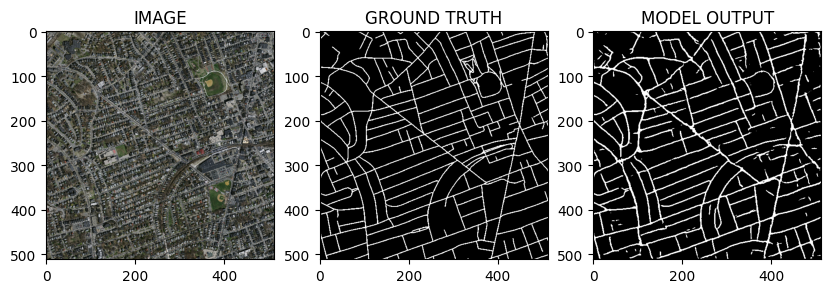

In [ ]:
helper.show_image(image, mask, pre_mask.detach().cpu().squeeze(0))